## Data Exploration and Preparation for Machine Learning

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Loading Data

In [2]:
example_data1 = xr.open_dataset("example_data1.nc")
example_data2 = xr.open_dataset("example_data2.nc")

In [3]:
example_data1

<xarray.Dataset>
Dimensions:                         (time: 33828)
Coordinates:
  * time                            (time) datetime64[ns] 2014-06-18T06:00:01...
Data variables:
    estimated_oxygen_concentration  (time) float32 ...
    deployment                      (time) float64 ...
    dissolved_oxygen                (time) float64 ...
    rollup_annotations_qc_results   (time) float64 ...
Attributes: (12/69)
    node:                               RIS01
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             dosta_abcdjm_sio_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                49.9775
    lon:                                -144.2463

## Interactive Plots

In [4]:
import plotly.graph_objects as go

### example_data1 (Deployment 2)

In [15]:
def interactive_plot(dataset):
    """
    Generate a plotly interactive plot with the provided dataset
    """
    
    
    # Generate local datetime
    local_time1 = dataset['time'] - pd.Timedelta(10,'h')

    # Plotly figure
    fig = go.Figure()

    # Mask for data selection based on flags 
    mask = dataset["rollup_annotations_qc_results"] == 3

    # Create trace of good (not flagged) values
    trace_good = go.Scatter(name='good',
                            x=local_time1[~mask],
                            y=dataset['estimated_oxygen_concentration'][~mask],
                            mode='markers',
                            marker=dict(dict(color='blue'))
                            )

    # Create trace of bad (flagged) values
    trace_bad = go.Scatter(name='bad',
                           x=local_time1[mask],
                           y=dataset['estimated_oxygen_concentration'][mask],
                           mode='markers',
                           marker=dict(dict(color='red'))
                           )
    # Add traces
    fig.add_trace(trace_good)
    fig.add_trace(trace_bad)

    # Format axis labels 
    fig.update_xaxes(title="Datetime")
    fig.update_yaxes(title="estimated oxygen concentration")
    
    return fig

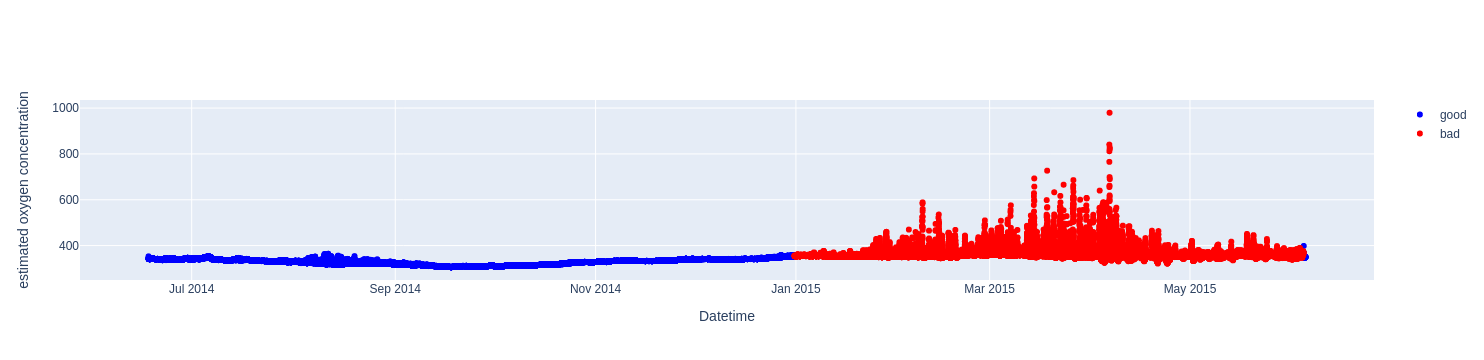

In [16]:
fig = interactive_plot(example_data1)
fig.show()

## Dataset Preparation for ML

### Day of Year generation

The goal is to generate days of year using the first year of a dataset as reference.

In [7]:
def doy(data):
    """
    List of days of year based on the first year of the dataset
    """
    
    min_year = data['time'].dt.year.min().data
    max_year = data['time'].dt.year.max().data
    years = np.arange(min_year,max_year+1,1)
    
    doys = []
    for count,year in enumerate(years):
        doy = data.sel(time=f'{year}')['time.dayofyear']
        doy += 365*(count)
        doys.extend(doy.data)
        
    return doys

In [8]:
def ddoy(data):
    """
    List of days of year (with decimals) based on the first year of the dataset
    """
    
    min_year = data['time'].dt.year.min().data
    max_year = data['time'].dt.year.max().data
    years = np.arange(min_year,max_year+1,1)
    
    ddoys = []
    for count,year in enumerate(years):
        doy = data.sel(time=f'{year}')['time.dayofyear']
        doy += 365*(count)
        hours_dec = data.sel(time=f'{year}')['time.hour'] / 24
        mins_dec = data.sel(time=f'{year}')['time.minute'] / (24*60)
        secs_dec = data.sel(time=f'{year}')['time.second'] / (24*60*60)
        ddoy = doy + hours_dec + mins_dec + secs_dec
        
        ddoys.extend(ddoy.data)
        
    return ddoys

In [9]:
# Creating doy and ddoy coordinates
# example_data1
doy1 = doy(example_data1)
ddoy1 = ddoy(example_data1)

example_data1['doy'] = doy1 
example_data1['ddoy'] = ddoy1

# example_data2
doy2 = doy(example_data2)
ddoy2 = ddoy(example_data2)

example_data2['doy'] = doy2
example_data2['ddoy'] = ddoy2

In [10]:
example_data1

<xarray.Dataset>
Dimensions:                         (time: 33828, doy: 33828, ddoy: 33828)
Coordinates:
  * time                            (time) datetime64[ns] 2014-06-18T06:00:01...
  * doy                             (doy) int64 169 169 169 169 ... 521 521 521
  * ddoy                            (ddoy) float64 169.3 169.3 ... 521.6 521.6
Data variables:
    estimated_oxygen_concentration  (time) float32 343.4 344.6 ... 350.6 350.6
    deployment                      (time) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    dissolved_oxygen                (time) float64 nan nan nan ... nan nan nan
    rollup_annotations_qc_results   (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/69)
    node:                               RIS01
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             dosta_abcdjm_sio_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                49.9775
    lon:                                -144.2463